# Praca domowa 4

In [4]:
import pandas as pd
import rdata
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from sklearn.svm import SVR, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn import datasets

## Apartments dataset
Za pomocą SVM zajmiemy się zadaniem regresji, a mianowicie będziemy przywidywać cenę metru kwadratowego mieszkania na podstawie reszty danych z ramki `apartments_df`.
### Exploration

In [2]:
parsed = rdata.parser.parse_file("apartments.rda")
converted = rdata.conversion.convert(parsed)
apartments_df = converted["apartments"]
apartments_df.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897.0,1953.0,25.0,3,1.0,Srodmiescie
1,1818.0,1992.0,143.0,9,5.0,Bielany
2,3643.0,1937.0,56.0,1,2.0,Praga
3,3517.0,1995.0,93.0,7,3.0,Ochota
4,3013.0,1992.0,144.0,6,5.0,Mokotow


In [3]:
apartments_df.info()
# nie ma braków
# kolumna district jest kategoryczna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   m2.price           1000 non-null   float64 
 1   construction.year  1000 non-null   float64 
 2   surface            1000 non-null   float64 
 3   floor              1000 non-null   int64   
 4   no.rooms           1000 non-null   float64 
 5   district           1000 non-null   category
dtypes: category(1), float64(4), int64(1)
memory usage: 40.6 KB


In [4]:
apartments_df.groupby("district").size()
# nie ma problemów z pisownią(np. Bemowo, bemowo, BEMOWO), 
# więc można odrazu zastosować one-hot encoding

district
Bemowo          98
Bielany         96
Mokotow        107
Ochota          96
Praga           92
Srodmiescie    100
Ursus          105
Ursynow        103
Wola           106
Zoliborz        97
dtype: int64

In [4]:
apartments_df.describe()

,m2.price,construction.year,surface,floor,no.rooms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000
std,906.691651,25.831511,37.874799,2.899876,1.381415
min,1607.000000,1920.000000,20.000000,1.000000,1.000000
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000
max,6595.000000,2010.000000,150.000000,10.000000,6.000000


### Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(apartments_df.drop("m2.price", axis=1), 
                                                    apartments_df["m2.price"], 
                                                    test_size=0.3, shuffle=True, random_state=42)

### Modeling

In [5]:
def get_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    return (r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False))

def modeling(X_train, y_train, scale=True, tune=True):
    
    params = dict({'clf__C': expon(scale = 100),
              'clf__gamma': expon(scale = .1),
              'clf__epsilon': expon(scale = 10)})
    
    ohe = OneHotEncoder(sparse=False)
    columns_to_encode = ["district"]
    
    if scale:
        scaler = StandardScaler()
        columns_to_scale = list(filter(lambda x: x != "district", X_train.columns.to_list()))

        pipeline = Pipeline(
            [("coltransformer", ColumnTransformer(
                transformers=[
                    ("other", Pipeline([("scale", scaler)]), columns_to_scale),
                    ("district", Pipeline([("encode", ohe)]), columns_to_encode),
                ]),
            ),
            ("clf", SVR(kernel="rbf"))]
        )    
    else:
        pipeline = Pipeline(
            [("coltransformer", ColumnTransformer(
                transformers=[
                    ("district", Pipeline([("encode", ohe)]), columns_to_encode),
                ]),
            ),
            ("clf", SVR(kernel="rbf"))]
        )
    
    if tune:
        random_search = RandomizedSearchCV(pipeline, 
                                           params, 
                                           scoring="r2", 
                                           random_state=0, n_jobs=-1)
        random_search.fit(X_train, y_train)
        clf = random_search.best_estimator_
    else:
        clf = pipeline.fit(X_train, y_train)
        
    return clf

def experiment(X_train, X_test, y_train, y_test):
    scale = [False, False, True, True]
    tune = [False, True, False, True]
    
    res_merged = None
    for i in range(4):
        clf = modeling(X_train, y_train, scale[i], tune[i])
        scores = get_scores(clf, X_test, y_test)
        res = pd.DataFrame.from_dict({"r2": [scores[0]], 
                                     "rmse": [scores[1]],
                                     "scale": [int(scale[i])],
                                     "tune": [int(tune[i])]})
        res_merged = pd.concat([res_merged, res], axis=0).reset_index(drop=True)
        
    return res_merged

## Digits dataset
Tutaj będziemy rozpoznawać cyfry, pisane przez ludzi, czyli klasyfikacja z wieloma klasami.

### Exploration

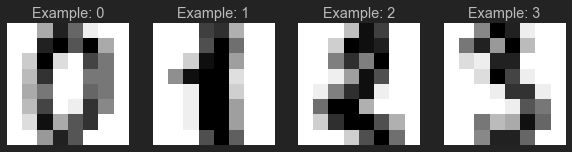

In [6]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Example: %i' % label)

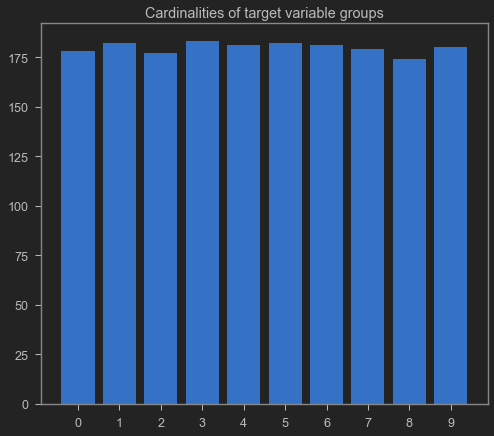

In [5]:
target_df = pd.DataFrame.from_dict({"target": digits.target})
target_df = target_df.groupby("target").size().reset_index(name="cardinality")

fig, axes = plt.subplots(1, 1)
axes.bar(target_df["target"], height=target_df["cardinality"])
axes.set_xticks(np.arange(0, 10))
axes.set_title("Cardinalities of target variable groups")
plt.show()
# target jest zrównoważony

### Train-test split

In [14]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
X_train2, X_test2, y_train2, y_test2 = train_test_split(data, 
                                                        digits.target, 
                                                        test_size=0.3, 
                                                        shuffle=True, random_state=42)
X_train2, X_test2 = pd.DataFrame(X_train2), pd.DataFrame(X_test2)

In [15]:
X_train2.shape

(1257, 64)

### Modeling

In [16]:
def get_scores2(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

def modeling2(X_train, y_train, scale=True, tune=True):
    
    params = dict({'clf__C': expon(scale = 100),
              'clf__gamma': expon(scale = .1)})
    
    if scale:

        model = Pipeline(
            [("scaler", MinMaxScaler()),
            ("clf", SVC(kernel="rbf"))])    
    else:
        model = Pipeline([("clf", SVC(kernel="rbf"))]) 
    
    if tune:
        random_search = RandomizedSearchCV(model, 
                                           params, 
                                           scoring="accuracy", 
                                           random_state=0, n_jobs=-1)
        random_search.fit(X_train, y_train)
        clf = random_search.best_estimator_
    else:
        clf = model.fit(X_train, y_train)
        
    return clf

def experiment2(X_train, X_test, y_train, y_test):
    scale = [False, False, True, True]
    tune = [False, True, False, True]
    
    res_merged = None
    for i in range(4):
        clf = modeling2(X_train, y_train, scale[i], tune[i])
        score = get_scores2(clf, X_test, y_test)
        res = pd.DataFrame.from_dict({"accuracy": [score],
                                     "scale": [int(scale[i])],
                                     "tune": [int(tune[i])]})
        res_merged = pd.concat([res_merged, res], axis=0).reset_index(drop=True)
        
    return res_merged

## Conclusion
### Apartments dataset
W tym zadaniu skalowanie było pomocne jedynie w przypadku strojenia hiperparametrów. 

In [11]:
experiment(X_train, X_test, y_train, y_test)

,r2,rmse,scale,tune
0,0.024483,896.087514,0,0
1,0.599579,574.105088,0,1
2,0.015657,900.132022,1,0
3,0.945491,211.820607,1,1


### Digits dataset
Tutaj podobnie ważne było zastosowanie skalowania w przypadku strojenia, ale w przeciwieństwie do poprzedniego przykładu model z domyślnymi hiperparametrami sprawdził się dobrze bez względu na to, czy było skalowanie użyte. 

In [17]:
experiment2(X_train2, X_test2, y_train2, y_test2)

,accuracy,scale,tune
0,0.987037,0,0
1,0.787037,0,1
2,0.987037,1,0
3,0.988889,1,1
